# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data
print('azdias shape: ', azdias.shape)
print('feat_info shape: ', feat_info.shape)

azdias shape:  (891221, 85)
feat_info shape:  (85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# quick copy for testing purposes
a = feat_info

# feat_info lists columns names in same order as azdias.columns
for i,V in enumerate(azdias.items()):
    m_u = a['missing_or_unknown'][i]
    
    # grab the column name from the first spot in the list of key value tuples returned by .items()
    column_name = V[0]
    
    # values in m_u are strings of a list (e.g. '[-1,0,9]'), so using slicing to remove the brackets and split values
    m_u = m_u[1:-1].split(',')
    
    # if m_u has actual values (e.g. it isn't a list with an empty string), replace values in azdias with NaN
    if m_u != ['']:
        hold = []
        
        for c in m_u:
            if c in ['X','XX']:
                hold.append(c)
            else: 
                hold.append(int(c))
    azdias[column_name] = azdias[column_name].replace(hold, np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 29.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   5.,   0.,  13.,
          5.,   6.,   7.,   6.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          2.]),
 array([      0.  ,    8890.61,   17781.22,   26671.83,   35562.44,
          44453.05,   53343.66,   62234.27,   71124.88,   80015.49,
          88906.1 ,   97796.71,  106687.32,  115577.93,  124468.54,
         133359.15,  142249.76,  151140.37,  160030.98,  168921.59,
         177812.2 ,  186702.81,  195593.42,  2

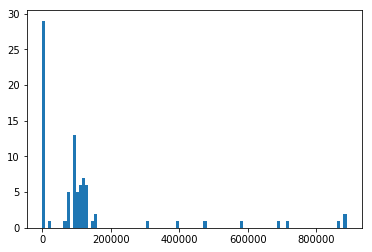

In [7]:
# Perform an assessment of how much missing data there is in each column of the dataset.
plt.hist(azdias.isnull().sum().sort_values(ascending=False), bins=100)

30 columns have minimal missing values. Nine columns have more than 1/3 of their values missing. These are the outliers. Another chunk of 42 columns have between 70k - 140k missing values.

In [8]:
# https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [9]:
# simplified non-function version: azdias.isnull().sum().sort_values(ascending=False)
missing_values_table(azdias)

Your selected dataframe has 85 columns.
There are 62 columns that have missing values.


,Missing Values,% of Total Values
TITEL_KZ,889061,99.8
ANZ_TITEL,888041,99.6
ANZ_HH_TITEL,867252,97.3
GREEN_AVANTGARDE,715996,80.3
AGER_TYP,685843,77.0
KK_KUNDENTYP,584612,65.6
KBA05_BAUMAX,476524,53.5
GEBURTSJAHR,392318,44.0
ALTER_HH,310267,34.8
REGIOTYP,158064,17.7


In [10]:
azdias.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
ANZ_TITEL                888041
ANZ_HH_TITEL             867252
GREEN_AVANTGARDE         715996
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG4              133324
MOBI_REGIO               133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_GBZ                133324
PLZ8_BAUMAX              116515
PLZ8_HHZ                 116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_ANTG2               116515
PLZ8_GBZ                 116515
PLZ8_ANTG1               116515
HEALTH_TYP               111196
VERS_TYP                 111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
                          ...  
HH_EINKO

In [11]:
# Investigate patterns in the amount of missing data in each column.
# Looked at Data_Dictionary.md to understand what the columns with the same number of missing values related to.

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Each of these dropped columns had more than 33% missing values.
azdias = azdias.drop(['TITEL_KZ', 'ANZ_TITEL', 'ANZ_HH_TITEL', 'GREEN_AVANTGARDE', 'AGER_TYP',
                      'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)
azdias.shape

(891221, 76)

#### Discussion 1.1.2: Assess Missing Data in Each Column

**Patterns in Missing Values:** 

37 columns have between ~88k and 133k missing values. A general theme is that many of these features are location-specific.
- 5 columns that start with 'KBA05_' all deal with the number of houses in the microcell and each have 133k missing values.
- 7 columns that start with 'PLZ8_' all concern buildings or houses in the PLZ8 region. Each of these 7 columns has 116k missing values.
- 3 columns that begin with 'CAMEO_' each have 99k missing values and relate to wealth / life stage typology.
- 3 postcode-level features ['BALLRAUM', 'EWDICHTE', 'INNENSTADT'] measure distances to urban areas or density and have ~94k missing values.

**Columns Removed From the Dataset:**

- The following columns had more than 33% missing values and were removed from the dataset: TITEL_KZ, ANZ_TITEL, ANZ_HH_TITEL, GREEN_AVANTGARDE, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH.
- The first 3 dropped columns (TITEL_KZ, ANZ_TITEL, ANZ_HH_TITEL) all relate to academic titles.
- The last two, GEBURTSJAHR and ALTER_HH, both relate to age (year of birth and birthdate of head of household, specifically).

---

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

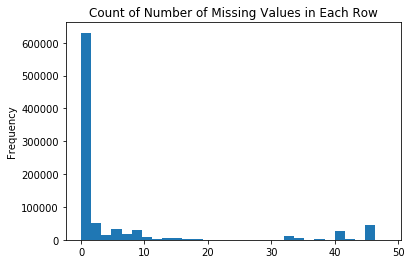

In [13]:
# How much data is missing in each row of the dataset?

# Sum the number of missing values across the columns (row-wise)
missing_row_data = azdias.isnull().sum(axis=1)
missing_row_data.plot(kind='hist', bins=30, title='Count of Number of Missing Values in Each Row');

From examing the chart above, it appears there are a large group of rows with less than 20 missing values and a second group of rows with more than 30 missing values.

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Create a boolean mask. Then use the mask to create two subsets

cutoff = 30
criteria = azdias.isnull().sum(axis=1) <= cutoff

lte_30_mv = azdias[criteria]
gt_30_mv = azdias[~criteria]

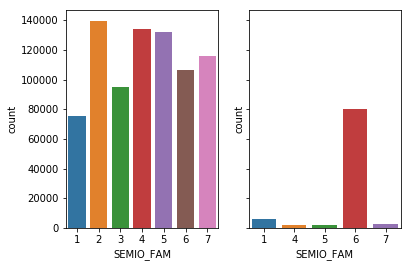

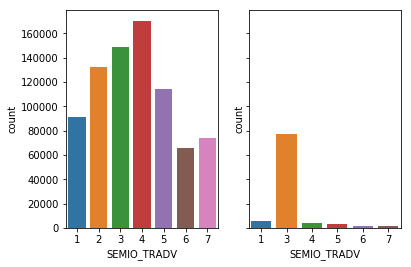

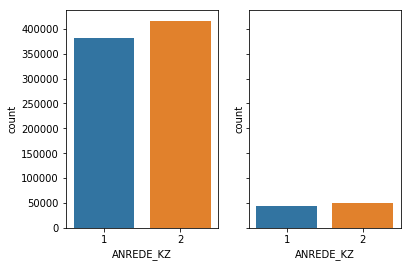

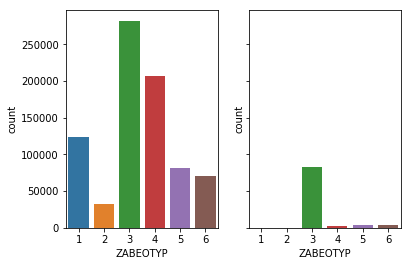

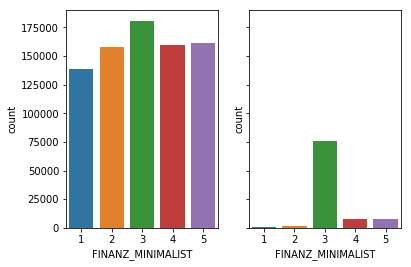

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_nan(dframe1, dframe2, colnames):
    for colname in colnames:
        f, ((ax1, ax2)) = plt.subplots(1, 2, sharey=True)
        sns.countplot(x=colname, data=dframe1, ax= ax1)
        sns.countplot(x=colname, data=dframe2, ax= ax2)
        plt.show()
plot_nan(lte_30_mv, gt_30_mv, ['SEMIO_FAM', 'SEMIO_TRADV', 'ANREDE_KZ', 'ZABEOTYP', 'FINANZ_MINIMALIST'])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?

The subset with lots of missing values looks much different than the subset with few or no missing values. In each of the plots using the small missing data subset, each of counts for the values look well distributed, whereas the subset with large missing values subset often only has one value with a large count.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

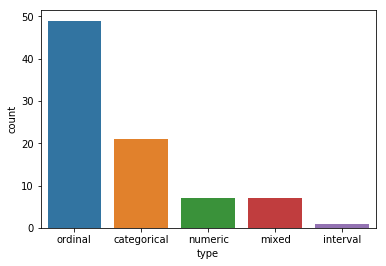

In [17]:
# Another option using pandas: feat_info['type'].value_counts().plot(kind='barh');
sns.countplot('type', data=feat_info, order = feat_info['type'].value_counts().index);

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# 21 categorical features
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


## Notes
- List of 21 categoricals and how many levels they have by looking them up in the data dictionary
- A better way to do this might be to look at a count of the unique values for each one to see if it's binary or multi


- AGER_TYP - multi (3 or more)
- ANREDE_KZ - binary (1: male, 2: female) excluding unknown -1 and can't be det 0
- CJT_GESAMTTYP - multi
- FINANZTYP - multi
- GFK_URLAUBERTYP - multi
- GREEN_AVANTGARDE - binary (0: not a member, 1: member)
- LP_FAMILIE_FEIN - multi
- LP_FAMILIE_GROB - multi
- LP_STATUS_FEIN - multi
- LP_STATUS_GROB - multi
- NATIONALITAET_KZ - multi
- SHOPPER_TYP - multi
- SOHO_KZ - binary (0: no small office, 1: small ofice), -1 unknown
- TITEL_KZ - multi
- VERS_TYP - binary (1: social-safety, 2: individ)
- ZABEOTYP - multi
- KK_KUNDENTYP - multi
- GEBAEUDETYP - binary (1: residentail building, 2: res build without known)

- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values 
 as numbers or create a dummy variable.
 OST_WEST_KZ: this is the one that takes on non-numeric values
    - binary but non-numeric (O: East, W: West)

- CAMEO_DEUG_2015 - multi
- CAMEO_DEU_2015 - multi

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# OST_WEST_KZ needs to re-encoded from 'O' and 'W'
def ost_west_mapping(x):
    if x == 'O':
        return 0
    elif x == 'W':
        return 1

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(ost_west_mapping)

In [20]:
azdias.shape

(891221, 76)

In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.
# One hot encode with pd.get_dummies()
# I've already dropped AGER_TYP, TITEL_KZ, KK_KUNDENTYP in step 1.1.2
one_hot_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

# One hot encode with pd.get_dummies() and drop the one_hot_cols
azdias = pd.concat([azdias.drop(one_hot_cols, axis=1), pd.get_dummies(azdias[one_hot_cols], columns=one_hot_cols)], axis=1)
azdias.shape

(891221, 185)

#### Discussion 1.2.1: Re-Encode Categorical Features

Report your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?

I re-encoded OST_WEST_KZ from a binary variable that had non-numeric values to values of 0 and 1. I then one hot encoded the remaning categorical variables that were multi-level.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# These are the mixed-type features
feat_info[(feat_info['type'] == 'mixed')]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


WOHNLAGE and PLZ8_BAUMAX look like a normal categorical vars that I can one hot encode.
KBA05_BAUMAX has already been dropped earlier in the cleaning process.
LP_LEBENSPHASE_FEIN: not sure how I would cleanly break this up, so I think just one hot encode (OHE).
LP_LEBENSPHASE_GROB: same thing as FEIN. OHE.

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# 1.18 in the data dictionary

def praeg_decade_mapping(x):
    if x in (1, 2):
        return 40
    elif x in (3, 4):
        return 50
    elif x in (5, 6, 7):
        return 60
    elif x in (8, 9):
        return 70
    elif x in (10, 11, 12, 13):
        return 80
    elif x in (14, 15):
        return 90

def praeg_movement_mapping(x):
    if x in (1,3,5,8,10,12,14):
        return 'Mainstream'
    elif x in (2,4,6,7,9,11,13,15):
        return 'Avantgarde'   
    
# Create a new column rather than overwriting the original    
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(praeg_decade_mapping)
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(praeg_movement_mapping)

In [24]:
azdias.shape

(891221, 187)

In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# 4.3 in the data dictionary

# For some reason, all of CAMEO_INTL_2015 keys are strings, so need to change what the function is expecting

def cameo_wealth_mapping(x):
    if x in ('11', '12', '13', '14', '15'):
        return 'Wealthy'
    elif x in ('21', '22', '23', '24', '25'):
        return 'Prosperous'
    elif x in ('31', '32', '33', '34', '35'):
        return 'Comfortable'
    elif x in ('41', '42', '43', '44', '45'):
        return 'Less Affluent'
    elif x in ('51', '52', '53', '54', '55'):
        return 'Poorer'

def cameo_life_mapping(x):
    if x in ('11', '21', '31', '41', '51'):
        return 'Pre-Family'
    elif x in ('12', '22', '32', '42', '52'):
        return 'Young Couples'
    elif x in ('13', '23', '33', '43', '53'):
        return 'School Age Children'
    elif x in ('14', '24', '34', '44', '54'):
        return 'Older Families'
    elif x in ('15', '25', '35', '45', '55'):
        return 'Elders'    
    
# Create a new column rather than overwriting the original    
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(cameo_wealth_mapping)
azdias['CAMEO_INTL_2015_LIFE'] = azdias['CAMEO_INTL_2015'].apply(cameo_life_mapping)

In [26]:
azdias.shape

(891221, 189)

In [27]:
# One hot encode the remaining four mixed features
# Also need to OHE my engineered features: 'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
#                                          'CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFE'
more_one_hot_cols = ['WOHNLAGE', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
                     'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
                     'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE']

# One hot encode with pd.get_dummies() and drop the one_hot_cols
azdias = pd.concat([azdias.drop(more_one_hot_cols, axis=1), pd.get_dummies(azdias[more_one_hot_cols], columns=more_one_hot_cols)], axis=1)
azdias.shape

(891221, 264)

#### Discussion 1.2.2: Engineer Mixed-Type Features
Which ones did you keep, which did you drop, and what engineering steps did you perform?

I kept all of the mixed variables except KBA05_BAUMAX, which had already been dropped earlier in the notebook due to large number of missing values. WOHNLAGE and PLZ8_BAUMAX looked like a normal categorical variables, so I chose to one hot encode (OHE) them. For LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, I'm not sure how I would cleanly break these up, so I will just OHE them. For all of the variables that I OHE, I then concatenated the newly created columns back on to the original dataframe and dropped the original mixed columns I used to generate the one hot encodings.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [28]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# I used these two mixed columns to engineer new features, so now it's time to drop them
cols_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

azdias = azdias.drop(cols_to_drop, axis=1)
azdias.shape

(891221, 262)

(array([ 227.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    4.,    0.,    0.,    7.,    4.,    1.,    3.,
           6.,    0.,    0.,    6.,    0.,    1.,    2.]),
 array([      0.  ,    6322.56,   12645.12,   18967.68,   25290.24,
          31612.8 ,   37935.36,   44257.92,   50580.48,   56903.04,
          63225.6 ,   69548.16,   75870.72,   82193.28,   88515.84,
          94838.4 ,  101160.96,  107483.52,  113806.08,  120128.64,
         126451.2 ,  132773.76,  139096.32,  145418.88,  151741.44,  158064.  ]),
 <a list of 25 Patch objects>)

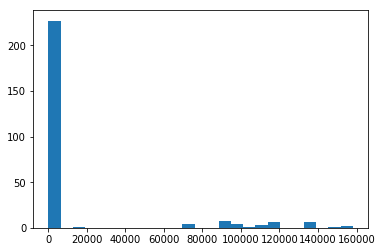

In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Now reexamine the proportion of missing values from each column to make sure there aren't any large outliers 
# remaining
plt.hist(azdias.isnull().sum().sort_values(ascending=False), bins=25)

In [30]:
missing_values_table(azdias)

Your selected dataframe has 262 columns.
There are 37 columns that have missing values.


,Missing Values,% of Total Values
KKK,158064,17.7
REGIOTYP,158064,17.7
W_KEIT_KIND_HH,147988,16.6
KBA05_GBZ,133324,15.0
KBA05_ANTG4,133324,15.0
KBA05_ANTG3,133324,15.0
KBA05_ANTG2,133324,15.0
KBA05_ANTG1,133324,15.0
MOBI_REGIO,133324,15.0
PLZ8_ANTG4,116515,13.1


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # quick copy for testing purposes
    a = feat_info

    # feat_info lists columns names in same order as azdias.columns
    for i,V in enumerate(df.items()):
        m_u = a['missing_or_unknown'][i]

        # grab the column name from the first spot in the list of key value tuples returned by .items()
        column_name = V[0]

        # values in m_u are strings of a list (e.g. '[-1,0,9]'), so using slicing to remove the brackets and split values
        m_u = m_u[1:-1].split(',')

        # if m_u has actual values (e.g. it isn't a list with an empty string), replace values in azdias with NaN
        if m_u != ['']:
            hold = []

            for c in m_u:
                if c in ['X','XX']:
                    hold.append(c)
                else: 
                    hold.append(int(c))
        df[column_name] = df[column_name].replace(hold, np.nan)
    
    # remove selected columns and rows, ...
    # drop rows with large amount of missing values in the original azdias dataset
    df = df.drop(['TITEL_KZ', 'ANZ_TITEL', 'ANZ_HH_TITEL', 'GREEN_AVANTGARDE', 'AGER_TYP',
                      'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)
    
    # select, re-encode, and engineer column values.
    
    # OST_WEST_KZ needs to re-encoded from 'O' and 'W'
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(ost_west_mapping)
    
    # Engineer new variables for "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015"
    # Do this step before the one hot step so I can do all of the OHE at the same time
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(praeg_decade_mapping)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(praeg_movement_mapping)
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(cameo_wealth_mapping)
    df['CAMEO_INTL_2015_LIFE'] = df['CAMEO_INTL_2015'].apply(cameo_life_mapping)
    
    # One hot encode with pd.get_dummies(). All hot encoding combined into one step rather than two above
    one_hot_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                    'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                    'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'WOHNLAGE', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 
                    'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
                     'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE']

    # One hot encode with pd.get_dummies() and drop the one_hot_cols
    df = pd.concat([df.drop(one_hot_cols, axis=1), pd.get_dummies(df[one_hot_cols], columns=one_hot_cols)], axis=1)
    
    # Drop original columns "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015"
    cols_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df = df.drop(cols_to_drop, axis=1)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# 37 columns still have missing values 
missing_values_table(azdias)

Your selected dataframe has 262 columns.
There are 37 columns that have missing values.


,Missing Values,% of Total Values
KKK,158064,17.7
REGIOTYP,158064,17.7
W_KEIT_KIND_HH,147988,16.6
KBA05_GBZ,133324,15.0
KBA05_ANTG4,133324,15.0
KBA05_ANTG3,133324,15.0
KBA05_ANTG2,133324,15.0
KBA05_ANTG1,133324,15.0
MOBI_REGIO,133324,15.0
PLZ8_ANTG4,116515,13.1


In [33]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html
# axis=0 imputes along columns
# Imputer returns an nd.array, so convert it back into a dataframe
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
azdias_imp = pd.DataFrame(imp.fit_transform(azdias))
azdias_imp.columns = azdias.columns
azdias_imp.index = azdias.index

In [34]:
# check to see if any missing values remain
missing_values_table(azdias_imp)

Your selected dataframe has 262 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [35]:
# Apply feature scaling to the general population demographics data.

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# StandardScaler returns an nd.array, so convert it back into a dataframe
ss = StandardScaler()
azdias_scaled = pd.DataFrame(ss.fit_transform(azdias_imp))
azdias_scaled.columns = azdias_imp.columns
azdias_scaled.index = azdias_imp.index

### Discussion 2.1: Apply Feature Scaling

Report your decisions regarding feature scaling.

There were 37 columns with missing values. I chose to replace the NaNs with the mean so that I could keep as much of the data as possible.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# Apply PCA to the data.
# Don't set any parameters on the first pass so all components are computed
pca = PCA().fit(azdias_scaled)

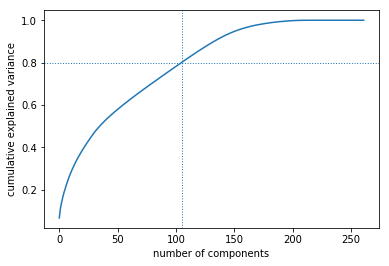

In [37]:
# Investigate the variance accounted for by each principal component.
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(x=105, linewidth=1, linestyle=':')
plt.axhline(y=0.8, linewidth=1, linestyle=':');

Around 105 principal components would allow me to retain around 80% of the explained variance. 30% of the variance can be captured in about 12 columns.

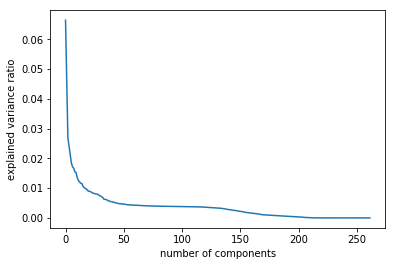

In [38]:
# Another view without the running total
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance ratio');

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Based on the plot above, pick an appropriate number of components to keep

# Good reference:
# https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

# https://stackoverflow.com/questions/29611842/scikit-learn-kernel-pca-explained-variance
pca3 = PCA(n_components=25, random_state=0).fit(azdias_scaled)

# Transform returns 25 columns
# When you call transform you're asking sklearn to actually do the projection. That is, you are 
# asking it to project each row of your data into the vector space that was learned when fit was called. 
# For each row of the data you pass to transform you'll have 1 row in the output and the number of columns 
# in that row will be the number of vectors that were learned in the fit phase. 
# In other words, the number of columns will be equal to the value of n_components you passed to the constructor.
pca_transform = pca3.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Report your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?

About 42% of the explained variance can be captured with 25 principal components. Looking at the explained variance ratio vs. number of components plot, the explained variance ratio value drops below 1% after only 17 principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Define a function that will grab the ith principal component and create sorted column results
def pc_weight_sorter(num):
    '''
    Given a value, returns the sorted weights for that principal component from pca output
    '''
    # Convert two lists into a dictionary
    ith_pc = list(pca3.components_[num])
    pca_columns = list(azdias_scaled.columns)
    ith_pc_dict = dict(zip(pca_columns, ith_pc))
    
    # Grab 5 largest and smallest weights
    five_largest = sorted(((v,k) for k,v in ith_pc_dict.items()), reverse=True)[:5]
    five_smallest = sorted(((v,k) for k,v in ith_pc_dict.items()), reverse=False)[:5]
    
    print('5 largest: ', list(col for value, col in five_largest))
    print(five_largest)
    print('\n')
    print('5 smallest: ', list(col for value, col in five_smallest))
    print(five_smallest)

In [41]:
print('1st PC')
pc_weight_sorter(0)

1st PC
5 largest:  ['LP_STATUS_GROB_1.0', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'HH_EINKOMMEN_SCORE', 'ORTSGR_KLS9']
[(0.17919445749126151, 'LP_STATUS_GROB_1.0'), (0.17594617610664268, 'PLZ8_ANTG3'), (0.16951903676387789, 'PLZ8_ANTG4'), (0.15406479401158796, 'HH_EINKOMMEN_SCORE'), (0.15136351824552011, 'ORTSGR_KLS9')]


5 smallest:  ['MOBI_REGIO', 'KBA05_ANTG1', 'PLZ8_ANTG1', 'FINANZ_MINIMALIST', 'KBA05_GBZ']
[(-0.19179069134673685, 'MOBI_REGIO'), (-0.17935142584683975, 'KBA05_ANTG1'), (-0.17553111587172626, 'PLZ8_ANTG1'), (-0.17283553535885882, 'FINANZ_MINIMALIST'), (-0.17069430551541595, 'KBA05_GBZ')]


In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print('2nd PC')
pc_weight_sorter(1)

2nd PC
5 largest:  ['FINANZ_VORSORGER', 'ALTERSKATEGORIE_GROB', 'SEMIO_ERL', 'RETOURTYP_BK_S', 'ZABEOTYP_3']
[(0.21854192260743871, 'FINANZ_VORSORGER'), (0.21806418245986331, 'ALTERSKATEGORIE_GROB'), (0.16151211880820848, 'SEMIO_ERL'), (0.15310800985018544, 'RETOURTYP_BK_S'), (0.15238000806249685, 'ZABEOTYP_3')]


5 smallest:  ['FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_ANLEGER', 'SEMIO_PFLICHT', 'SEMIO_REL']
[(-0.22917462072902087, 'FINANZ_SPARER'), (-0.21079160748568368, 'FINANZ_UNAUFFAELLIGER'), (-0.20604075988428175, 'FINANZ_ANLEGER'), (-0.1975179423850778, 'SEMIO_PFLICHT'), (-0.19577691006642281, 'SEMIO_REL')]


In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print('3rd PC')
pc_weight_sorter(2)

3rd PC
5 largest:  ['SEMIO_VERT', 'SEMIO_KULT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SHOPPER_TYP_0.0']
[(0.32070685266267973, 'SEMIO_VERT'), (0.27544870778531733, 'SEMIO_KULT'), (0.27104984017876016, 'SEMIO_SOZ'), (0.18490580467797726, 'SEMIO_FAM'), (0.1344634949668487, 'SHOPPER_TYP_0.0')]


5 smallest:  ['SEMIO_KAEM', 'ANREDE_KZ', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_ERL']
[(-0.31093431901641982, 'SEMIO_KAEM'), (-0.28958125695310866, 'ANREDE_KZ'), (-0.28924851959488451, 'SEMIO_KRIT'), (-0.27982898116456051, 'SEMIO_DOM'), (-0.15883007308841274, 'SEMIO_ERL')]


### Discussion 2.3: Interpret Principal Components

Report your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?

- **1st PC: Associated with low income**
    - Positive weights:
        - LP_STATUS_GROB_1.0 is the OHE social status, with 1 referring to low-income earners
        - PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region. Ordinal variable
        - PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region. Ordinal variable
        - HH_EINKOMMEN_SCORE: Estimated household net income
        - ORTSGR_KLS9: Size of community
    - Negative weights:
        - MOBI_REGIO: Movement patterns
        - KBA05_ANTG1: Number of 1-2 family houses in the microcell
        - PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region


- **2nd PC: Associated with shopping and high spending behavior**
    - Positive weights:
        - FINANZ_VORSORGER: Financial typology for 'be prepared'
        - ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
        - SEMIO_ERL: Personality typology for 'event-oriented'
        - RETOURTYP_BK_S: Return type (related to what type of shopper they are)
        - ZABEOTYP_3: OHE for energy consumption typology == 'fair supplied'
    - Negative weights:
        - FINANZ_SPARER: Financial typology for 'money-saver'
        - FINANZ_UNAUFFAELLIGER: Financial typology for inconspicuous
        - FINANZ_ANLEGER: Financial typology for investor


- **3rd PC: Associated with socially-oriented dreamers who are not harsh with their thinking**
    - Positive weights:
        - SEMIO_VERT: Personality typology for dreamful
        - SEMIO_KULT: Personality typology for cultural-minded
        - SEMIO_SOZ: Personality typology for socially-minded
        - SEMIO_FAM: Personality typology for family-minded
        - SHOPPER_TYP_0.0: OHE for shopper typology == 'external supplied hedonists'
    - Negative weights:
        - SEMIO_KAEM: Personality typology for combative attitude
        - ANREDE_KZ: Gender
        - SEMIO_KRIT: Personality typology for critical-minded 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
# Fit KMeans on my PCA-transformed data: pca_transform

# KMeans is slow so use MiniBatch KMeans to assess a large number of cluster sizes much faster, then use KMeans
# to create the final set

# Over a number of different cluster counts...
scores2 = []
cluster_sizes2 = [2,3,4,5,6,7,8,9,10,15,20,25,30]
for cluster in cluster_sizes2:
    # Run k-means clustering on the data
    km2 = MiniBatchKMeans(n_clusters=cluster).fit(pca_transform)
    
    # Compute the average within-cluster distances
    scores2.append(km2.score(pca_transform))

Note on KMeans.score from Slack channel:
It’s actually the negative of the total distance from each point to its assigned cluster’s centroid. The reason why it’s negative is because sklearn, as a consistency measure, wants its scoring functions to all consider higher values as better. Since we want to minimize average or total distance, we need to take the negative of distance in order for better outcomes to be considered better!

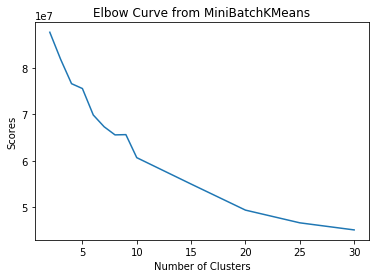

In [45]:
# plot n_clusters vs. scores from MiniBatchKMeans
plt.plot(cluster_sizes2,np.abs(scores2))
plt.xlabel('Number of Clusters')
plt.ylabel('Scores')
plt.title('Elbow Curve from MiniBatchKMeans')
plt.show()

Looking at the above plot, 15 clusters seem like a good starting spot for number of cluster to use.

In [46]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
km_final = KMeans(n_clusters=15).fit(pca_transform)
predictions = km_final.predict(pca_transform)

### Discussion 3.1: Apply Clustering to General Population

Report your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?

After plotting the scores for a number of different cluster sizes, I selected 15 clusters as the approximate inflection point to use to continue the analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [48]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Utilize clean_data() function written earlier in the notebook
customers_clean = clean_data(customers)

In [49]:
customers_clean.shape

(191652, 262)

In [50]:
# While customers dataset is smaller in terms of number of records, it has a larger percentage of missing values
missing_values_table(customers_clean)

Your selected dataframe has 262 columns.
There are 37 columns that have missing values.


,Missing Values,% of Total Values
KKK,60064,31.3
REGIOTYP,60064,31.3
W_KEIT_KIND_HH,56937,29.7
KBA05_GBZ,55982,29.2
KBA05_ANTG4,55980,29.2
KBA05_ANTG3,55980,29.2
KBA05_ANTG2,55980,29.2
KBA05_ANTG1,55980,29.2
MOBI_REGIO,55980,29.2
ANZ_PERSONEN,53742,28.0


In [51]:
# Imputer
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html
# axis=0 imputes along columns
# Imputer returns an nd.array, so convert it back into a dataframe
cust_imp = pd.DataFrame(imp.transform(customers_clean))
cust_imp.columns = customers_clean.columns
cust_imp.index = customers_clean.index

In [52]:
missing_values_table(cust_imp)

Your selected dataframe has 262 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [53]:
# Feature Scaling

# StandardScaler returns an nd.array, so convert it back into a dataframe
cust_scaled = pd.DataFrame(ss.transform(cust_imp))
cust_scaled.columns = cust_imp.columns
cust_scaled.index = cust_imp.index

In [54]:
# PCA
cust_scaled_pca_transform = pca3.transform(cust_scaled)

In [55]:
# KMeans
cust_predictions = km_final.predict(cust_scaled_pca_transform)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [56]:
# Count customer predictions that fall into each cluster. Then turn the count into a percentage
cluster_number_test, cust_count = np.unique(cust_predictions, return_counts=True)
cust_count_perc = cust_count / np.sum(cust_count)

# Count general predictions that fall into each cluster
cluster_number_test2, gen_count = np.unique(predictions, return_counts=True)
gen_count_perc = gen_count / np.sum(gen_count)

# Create a dataframe with the columns of interest stacked together
percent_df = pd.DataFrame(np.column_stack([cluster_number_test, cust_count_perc, gen_count_perc]), 
                               columns=['cluster_num', 'cust_count_perc', 'gen_count_perc'])

# Convert cluster_num to an int
percent_df['cluster_num'] = percent_df['cluster_num'].astype(int)
percent_df.head()

,cluster_num,cust_count_perc,gen_count_perc
0,0,0.071865,0.037638
1,1,0.236491,0.079389
2,2,0.006042,0.087423
3,3,0.049600,0.078109
4,4,0.067017,0.070978


In [57]:
# Reshape data so I will be able to pass 'group' to hue in Seaborn plotting options
percent_df_reshaped = pd.melt(percent_df, id_vars='cluster_num', var_name='group', value_name='percentage')
percent_df_reshaped.head(5)

,cluster_num,group,percentage
0,0,cust_count_perc,0.071865
1,1,cust_count_perc,0.236491
2,2,cust_count_perc,0.006042
3,3,cust_count_perc,0.049600
4,4,cust_count_perc,0.067017


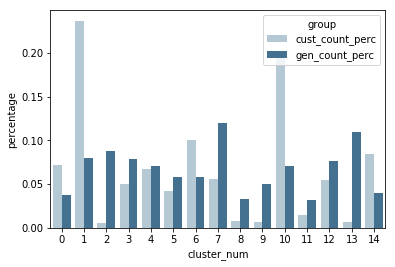

In [58]:
# Compare the proportion of data in each cluster for the customer data to the proportion of data in each 
# cluster for the general population.

# Reference: https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots?rq=1
sns.barplot(x='cluster_num', y='percentage', hue='group', data=percent_df_reshaped, saturation=.5, palette='Paired');

In [59]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 11 looks like a good candidate for this, with ~24% of customer data falling into this cluster vs. 8% 
# for the general dataset.

# There are 15 clusters from my choice of k earlier
clust_11 = km_final.cluster_centers_[11]
print('PCA values \n', clust_11)

# Find the top 2 largest values for the PCA values
# Reference: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
ind_11 = np.argpartition(clust_11, -2)[-2:]
print('Indices: ', ind_11)
print('Top values: ', clust_11[ind_11])
# These store the 25 principal component values associated with that particular cluster

# Take the two highest means of these principal components and then do the same analysis I did earlier
# np.argmax(km_final.cluster_centers_[11])
# 8th PC has the largest value

# Find the biggest/smallest PC values and then try to look them up in the data_dictionary, similarly
# to what I did earlier in the notebook

PCA values 
 [-4.32291836 -3.88936036  1.49000029  2.1311106   1.08315684  0.08276917
 -2.06678335  0.11202372 -1.20504878  0.98826613  0.93520325 -0.07873914
 -1.12511247 -0.83032181 -0.65638713  1.62334617  1.2880827   1.09292925
 -0.47612974  3.54207248 -0.14566165  1.35834249  1.47424275 -0.37842367
  1.32696686]
Indices:  [ 3 19]
Top values:  [ 2.1311106   3.54207248]


So, 8th and 10th principal components have the largest weights. Let's use the function from earlier in the notebook combined with the data dictionary to investigate these PCs.

In [60]:
# Map weights for the 8th principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print('8th PC')
pc_weight_sorter(7)

8th PC
5 largest:  ['LP_FAMILIE_GROB_4.0', 'LP_LEBENSPHASE_GROB_8.0', 'LP_LEBENSPHASE_FEIN_27.0', 'LP_FAMILIE_FEIN_7.0', 'LP_FAMILIE_FEIN_8.0']
[(0.25534160689576668, 'LP_FAMILIE_GROB_4.0'), (0.21421922859200848, 'LP_LEBENSPHASE_GROB_8.0'), (0.17130135187778076, 'LP_LEBENSPHASE_FEIN_27.0'), (0.16312072234429412, 'LP_FAMILIE_FEIN_7.0'), (0.16198429736059469, 'LP_FAMILIE_FEIN_8.0')]


5 smallest:  ['LP_FAMILIE_FEIN_2.0', 'LP_FAMILIE_GROB_2.0', 'LP_LEBENSPHASE_GROB_4.0', 'LP_LEBENSPHASE_GROB_5.0', 'FINANZTYP_1']
[(-0.22945336430907445, 'LP_FAMILIE_FEIN_2.0'), (-0.22945336430907445, 'LP_FAMILIE_GROB_2.0'), (-0.16008233893880802, 'LP_LEBENSPHASE_GROB_4.0'), (-0.15423457074658514, 'LP_LEBENSPHASE_GROB_5.0'), (-0.15329604112978221, 'FINANZTYP_1')]


- **8th PC: Associated with high income families with grown children**
    - Positive weights:
        - LP_FAMILIE_GROB_4.0: OHE family type for **family** (as opposed to single or couple)
        - LP_LEBENSPHASE_GROB_8.0: OHE life stage (rough scale) for **high-income earner families**
        - LP_LEBENSPHASE_FEIN_27.0: OHE life stage (fine scale) for **homeowner families**
        - LP_FAMILIE_FEIN_7.0: OHE family type (fine scale) for **family with teenager**
        - LP_FAMILIE_FEIN_8.0: OHE family type (fine scale) for **family with child of full age**
    - Negative weights:
        - LP_FAMILIE_FEIN_2.0: OHE family type (fine scale) for couple
        - LP_FAMILIE_GROB_2.0: OHE family type (rough scale) for couple
        - LP_LEBENSPHASE_GROB_4.0: OHE life stage (rough scale) for single low-income and average-earner couples

In [61]:
print('10th PC')
pc_weight_sorter(9)

10th PC
5 largest:  ['LP_LEBENSPHASE_GROB_6.0', 'LP_FAMILIE_GROB_3.0', 'LP_LEBENSPHASE_FEIN_21.0', 'LP_FAMILIE_FEIN_4.0', 'LP_LEBENSPHASE_FEIN_23.0']
[(0.27468368209597677, 'LP_LEBENSPHASE_GROB_6.0'), (0.27468368209597677, 'LP_FAMILIE_GROB_3.0'), (0.18158662241720536, 'LP_LEBENSPHASE_FEIN_21.0'), (0.1786428191467013, 'LP_FAMILIE_FEIN_4.0'), (0.17750830008360977, 'LP_LEBENSPHASE_FEIN_23.0')]


5 smallest:  ['LP_FAMILIE_GROB_4.0', 'LP_LEBENSPHASE_GROB_7.0', 'LP_STATUS_GROB_2.0', 'LP_FAMILIE_FEIN_8.0', 'LP_STATUS_FEIN_4.0']
[(-0.22675124864657964, 'LP_FAMILIE_GROB_4.0'), (-0.19480194345842533, 'LP_LEBENSPHASE_GROB_7.0'), (-0.15494112251019115, 'LP_STATUS_GROB_2.0'), (-0.15102892470745791, 'LP_FAMILIE_FEIN_8.0'), (-0.15089959663401717, 'LP_STATUS_FEIN_4.0')]


- **10th PC: Associated with single parents**
    - Positive weights:
        - LP_LEBENSPHASE_GROB_6.0: OHE life stage (rough scale) for **single parents**
        - LP_FAMILIE_GROB_3.0: OHE family type (rough scale) for **single parent**
        - LP_LEBENSPHASE_FEIN_21.0: OHE life stage (fine scale) for **single parent low-income earners**
        - LP_FAMILIE_FEIN_4.0: OHE family type (fine scale) for **single parent with teenager**
        - LP_LEBENSPHASE_FEIN_23.0: OHE life stage (fine scale) for **single parent high-income earners**
    - Negative weights:
        - LP_FAMILIE_GROB_4.0: OHE family type (rough scale) for **family**
        - LP_LEBENSPHASE_GROB_7.0: OHE life stage (rough scale) for single low-income and average earner **families**
        - LP_STATUS_GROB_2.0: OHE social status (rough scale) for average earners

In [62]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Cluster 10 looks like a good candidate for this, with ~1% of customer data falling into this cluster vs. 11% for 
# the general dataset.

clust_10 = km_final.cluster_centers_[10]
print('PCA values \n', clust_10)

# Find the top 2 largest values for the PCA values
# Reference: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
ind_10 = np.argpartition(clust_10, -2)[-2:]
print('Indices: ', ind_10)
print('Top values: ', clust_10[ind_10])

PCA values 
 [-4.65809493  1.95157309  0.72764734  2.8072138  -1.80474242  2.03452245
 -1.86611934 -0.87970414 -0.33027602  0.28268089 -0.61633    -1.06470361
 -0.75027637 -0.36222763  0.42608169 -0.61919277  0.24486388 -0.72006462
  0.98256561 -0.34955578 -0.31998721 -0.35333048 -0.1681609   0.64475868
 -0.42582899]
Indices:  [5 3]
Top values:  [ 2.03452245  2.8072138 ]


Look into the 1st and 3rd principal components (indices 0 and 2).

### Discussion 3.3: Compare Customer Data to Demographics Data

- People in cluster 11 are overrepresented in the customer data compared to the general population
    - I investigated the 8th and 10th principal components. The 8th PC is associated with high income families with grown children, while the 10th PC is associated with single parents. **Bringing these two components together, the customer data has more high income families than the general population. This suggests that high income families are part of the target audience for the company**


- People in cluster 10 are underrepresented in the customer data compared to the general population
    - I already examined the 1st and 3rd principal components earlier in section 2.3. The 1st principal component is associated with lower income, and the 3rd PC is associated with socially-oriented dreamers who are not harsh with their thinking. **Combining these two components, cluster 10 describes a lower income and more socially-oriented population that is underrepresented in the cusomter data compared to the general population.**